# Statistical Proof of a Gain in Performance

Assume that the code of a computing engine has been improved.  
How do you prove that the execution time has been improved?  
And by how much?  

### Compare base/new

The methodology consists in comparing the execution times before and after the change.  
Comparing only 2 runs, before and after, is not enough, especially when a cluster is involved,  
because part of the variations come from the variations of the cluster activity, the network ...   

Then, it is more precise to run equivalent tasks multiple times, before and after the change,  
to determine the sample distributions before and after, and to compare the before/after  
distributions in pairs.  

![alt text](img/image.png)
![alt text](img/image-1.png)

The pairwise comparison is represented as a :
* matrix of `---` (success) and `XXX` (failure)  
<img src= "img/image-2.png" alt="matrix of --- and XXX" style="border: 2px solid grey;">
* matrix of pvalues (except for the naiv test)  
<img src= "img/image-3.png" alt="matrix of pvalues" style="border: 2px solid grey;">


The `data/run_data.csv` file contains the runtimes of 10 batches of 30 tasks, 5 before and 5 after the change.  
The code before change is called : `base` or `bas`. The code after change is called : `new`.  

### Statistical comparison

The the distributions are ploted and compared. It is obvious that the new code is faster, i.e. `new < base`.  
To determine by how much, a factor k is used and manually determined to test the following : `new < k * base`.  
The best value of k is manually determined by dichotomy.  

To prove this, 3 statistical tests are performed:
1. **naiv test** : `new` is simply compared to `k*base`  
2. **t-test** : this test is valid when the sample size is large, even when the distribution is not normal  
3. **Mann-Whitney-U test** : this test is non-parametric  


### Results


| Test              | Results            |
| ----------------- | ------------------ |
| 1- naiv test      | new < **0.59** * base  |
| 2- t-test         | new < **0.648** * base |
| 3- Mann-Whitney-U | new < **0.655** * base |

Each test gives a similar best k factor : **0.59 -- 0.648 -- 0.655**  
Since the worst factor, **0.655**, is greater than 0.57 and 0.638, it passes all tests.

#### Conclusion

It has been statistically proved that the runtime has been improved by at least a factor of **0.655.**  
In other terms, there is at least a **34.5 % runtime improvement**.



# Code of the Analysis

In [94]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, ttest_ind

In [95]:
def get_run_stats(run_id) -> pd.DataFrame:
    df = pd.read_csv("data/run_data.csv")
    run_dict = { 'run_id': run_id, 'time': df[run_id] }
    run_df = pd.DataFrame(run_dict)
    return(run_df)
    """
    sns.histplot(run_df['run'].astype('float64'),
                 kde = True,
                 stat = 'density',
                 edgecolor = 'none',
                 kde_kws = {'cut: 3'}).set_title(run_id)
    """

In [96]:
def get_runs(run_ids):
    df_lst = []
    # create run df
    for run_id in run_ids:
        df = get_run_stats(run_id)
        df_lst.append(df)
    res = pd.concat(df_lst)
    return(res)

In [97]:
bas_run_ids = ['bas1', 'bas2', 'bas3', 'bas4', 'bas5']
new_run_ids = ['new1', 'new2', 'new3', 'new4', 'new5']

bas_df = get_runs(bas_run_ids)
new_df = get_runs(new_run_ids)

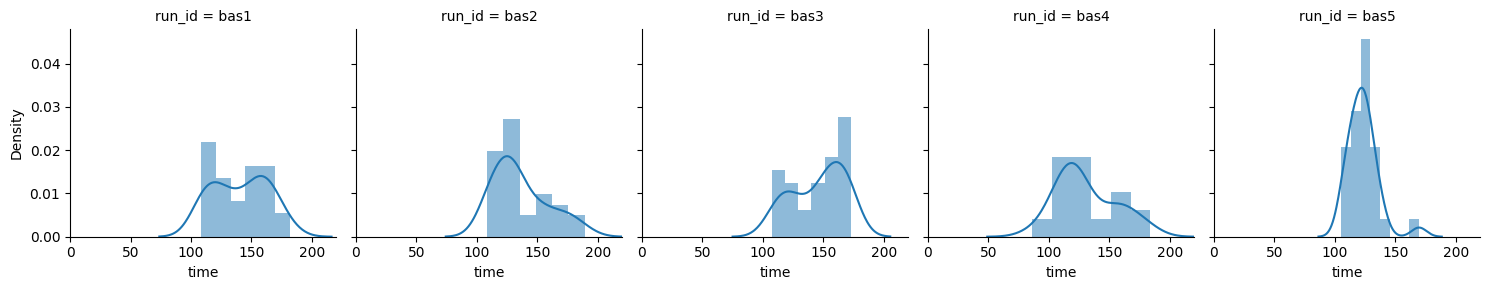

In [98]:
g = sns.FacetGrid(bas_df, col = 'run_id', xlim = (0,220))
g.map(sns.histplot, 'time', kde = True, stat = 'density', edgecolor = 'none', kde_kws = {'cut': 3})
plt.show()

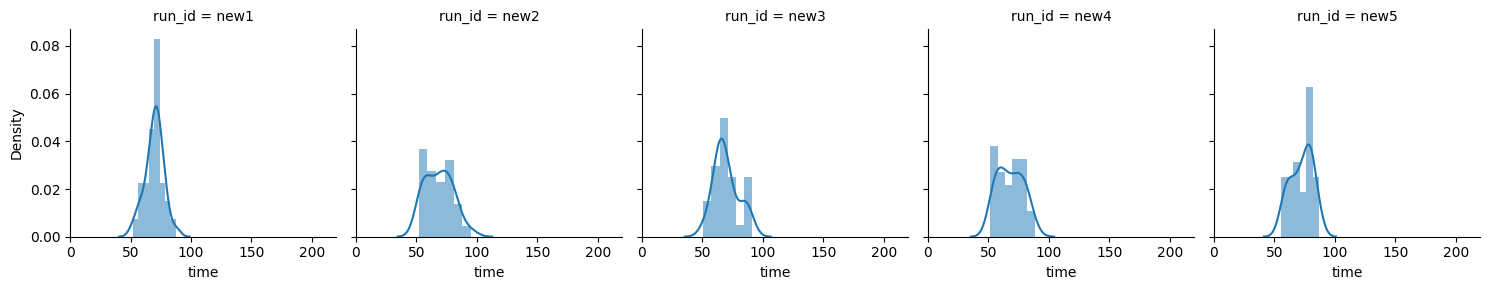

In [99]:
g = sns.FacetGrid(new_df, col = 'run_id', xlim = (0,220))
g.map(sns.histplot, 'time', kde = True, stat = 'density', edgecolor = 'none', kde_kws = {'cut': 3})
plt.show()

### Comparison of means with a factor k : naiv comparison

H0: k * base <= new  
H1: k * base >  new

In [100]:
k = 0.59
space_interval = '                   \t'
n_runs = 5
test_succeeded = True
for bas_idx in range(n_runs):
    for _ in range(bas_idx):
        print(space_interval, end = '')
    for new_idx in range(bas_idx, n_runs):
        bas_run_id = bas_run_ids[bas_idx]
        new_run_id = new_run_ids[new_idx]
        bas = k * bas_df[bas_df['run_id'] == bas_run_id]['time']
        new =     new_df[new_df['run_id'] == new_run_id]['time']
        res = new.mean() < bas.mean()
        test_succeeded = test_succeeded & res
        flag = '---' if res == True else 'XXX'
        print(f'({bas_run_id}-{new_run_id}) => {flag}', end = '\t')
    print()

if test_succeeded:
    print(f'SUCCESS : new < {k} * base')
else:
    print(f'FAILED : new >= {k} * base')

(bas1-new1) => ---	(bas1-new2) => ---	(bas1-new3) => ---	(bas1-new4) => ---	(bas1-new5) => ---	
                   	(bas2-new2) => ---	(bas2-new3) => ---	(bas2-new4) => ---	(bas2-new5) => ---	
                   	                   	(bas3-new3) => ---	(bas3-new4) => ---	(bas3-new5) => ---	
                   	                   	                   	(bas4-new4) => ---	(bas4-new5) => ---	
                   	                   	                   	                   	(bas5-new5) => ---	
SUCCESS : new < 0.59 * base


### Comparison of means with a factor k : t-test

H0: k * base <= new  
H1: k * base >  new

significance = 0.001

In [101]:
significance = 0.001
k = 0.648
space_interval = '                   \t'
n_runs = 5
test_succeeded = True
for bas_idx in range(n_runs):
    for _ in range(bas_idx):
        print(space_interval, end = '')
    for new_idx in range(bas_idx, n_runs):
        bas_run_id = bas_run_ids[bas_idx]
        new_run_id = new_run_ids[new_idx]
        bas = k * bas_df[bas_df['run_id'] == bas_run_id]['time']
        new =     new_df[new_df['run_id'] == new_run_id]['time']
        pvalue = ttest_ind(bas, new, alternative = 'greater').pvalue
        res = pvalue < significance
        test_succeeded = test_succeeded & res
        flag = '---' if res == True else 'XXX'
        print(f'({bas_run_id}-{new_run_id}) => {flag}', end = '\t')
    print()

if test_succeeded:
    print(f'SUCCESS : new < {k} * base')
else:
    print(f'FAILED : new >= {k} * base')

(bas1-new1) => ---	(bas1-new2) => ---	(bas1-new3) => ---	(bas1-new4) => ---	(bas1-new5) => ---	
                   	(bas2-new2) => ---	(bas2-new3) => ---	(bas2-new4) => ---	(bas2-new5) => ---	
                   	                   	(bas3-new3) => ---	(bas3-new4) => ---	(bas3-new5) => ---	
                   	                   	                   	(bas4-new4) => ---	(bas4-new5) => ---	
                   	                   	                   	                   	(bas5-new5) => ---	
SUCCESS : new < 0.648 * base


In [102]:
significance = 0.001
k = 0.648
space_interval = '                   \t'
n_runs = 5
for bas_idx in range(n_runs):
    for _ in range(bas_idx):
        print(space_interval, end = '')
    for new_idx in range(bas_idx, n_runs):
        bas_run_id = bas_run_ids[bas_idx]
        new_run_id = new_run_ids[new_idx]
        bas = k * bas_df[bas_df['run_id'] == bas_run_id]['time']
        new =     new_df[new_df['run_id'] == new_run_id]['time']
        pvalue = round(ttest_ind(bas, new, alternative = 'greater').pvalue, 4)
        print(f'({bas_run_id}-{new_run_id}) => {pvalue}', end = '\t')
    print()


(bas1-new1) => 0.0	(bas1-new2) => 0.0	(bas1-new3) => 0.0	(bas1-new4) => 0.0	(bas1-new5) => 0.0	
                   	(bas2-new2) => 0.0	(bas2-new3) => 0.0	(bas2-new4) => 0.0	(bas2-new5) => 0.0	
                   	                   	(bas3-new3) => 0.0	(bas3-new4) => 0.0	(bas3-new5) => 0.0	
                   	                   	                   	(bas4-new4) => 0.0	(bas4-new5) => 0.0003	
                   	                   	                   	                   	(bas5-new5) => 0.0009	


### Comparison of means with a factor k : Mann-Whitney-U (non-parametric)

H0: k * base <= new  
H1: k * base >  new

significance = 0.001

In [103]:
significance = 0.001
k = 0.655
space_interval = '                   \t'
n_runs = 5
test_succeeded = True
for bas_idx in range(n_runs):
    for _ in range(bas_idx):
        print(space_interval, end = '')
    for new_idx in range(bas_idx, n_runs):
        bas_run_id = bas_run_ids[bas_idx]
        new_run_id = new_run_ids[new_idx]
        bas = k * bas_df[bas_df['run_id'] == bas_run_id]['time']
        new =     new_df[new_df['run_id'] == new_run_id]['time']
        pvalue = mannwhitneyu(bas, new, alternative = 'greater').pvalue
        res = pvalue < significance
        test_succeeded = test_succeeded & res
        flag = '---' if res == True else 'XXX'
        print(f'({bas_run_id}-{new_run_id}) => {flag}', end = '\t')
    print()

if test_succeeded:
    print(f'SUCCESS : new < {k} * base')
else:
    print(f'FAILED : new >= {k} * base')

(bas1-new1) => ---	(bas1-new2) => ---	(bas1-new3) => ---	(bas1-new4) => ---	(bas1-new5) => ---	
                   	(bas2-new2) => ---	(bas2-new3) => ---	(bas2-new4) => ---	(bas2-new5) => ---	
                   	                   	(bas3-new3) => ---	(bas3-new4) => ---	(bas3-new5) => ---	
                   	                   	                   	(bas4-new4) => ---	(bas4-new5) => ---	
                   	                   	                   	                   	(bas5-new5) => ---	
SUCCESS : new < 0.655 * base


In [104]:
significance = 0.001
k = 0.655
space_interval = '                   \t'
n_runs = 5
for bas_idx in range(n_runs):
    for _ in range(bas_idx):
        print(space_interval, end = '')
    for new_idx in range(bas_idx, n_runs):
        bas_run_id = bas_run_ids[bas_idx]
        new_run_id = new_run_ids[new_idx]
        bas = k * bas_df[bas_df['run_id'] == bas_run_id]['time']
        new =     new_df[new_df['run_id'] == new_run_id]['time']
        pvalue = round( mannwhitneyu(bas, new, alternative = 'greater').pvalue, 4)
        print(f'({bas_run_id}-{new_run_id}) => {pvalue}', end = '\t')
    print()


(bas1-new1) => 0.0	(bas1-new2) => 0.0	(bas1-new3) => 0.0	(bas1-new4) => 0.0	(bas1-new5) => 0.0	
                   	(bas2-new2) => 0.0	(bas2-new3) => 0.0	(bas2-new4) => 0.0	(bas2-new5) => 0.0	
                   	                   	(bas3-new3) => 0.0	(bas3-new4) => 0.0	(bas3-new5) => 0.0	
                   	                   	                   	(bas4-new4) => 0.0	(bas4-new5) => 0.0009	
                   	                   	                   	                   	(bas5-new5) => 0.0009	
